In [1]:
# Author: Yilin Zheng
# Reference: https://github.com/preritj/Vechicle-Detection-Tracking/blob/master/Project.ipynb
# import necessary libraries
import numpy as np
import pandas as pd
import random
from PIL import Image
from skimage.feature import local_binary_pattern
from skimage.feature import hog
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
import cv2
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# Read and Split data

In [2]:
# read data
vehicles = glob.glob("./vehicles/*/*.*")
non_vehicles = glob.glob("./non-vehicles/*/*.*")

Number of positive images: 8792
Image size is (64, 64, 3)
Image type: uint8


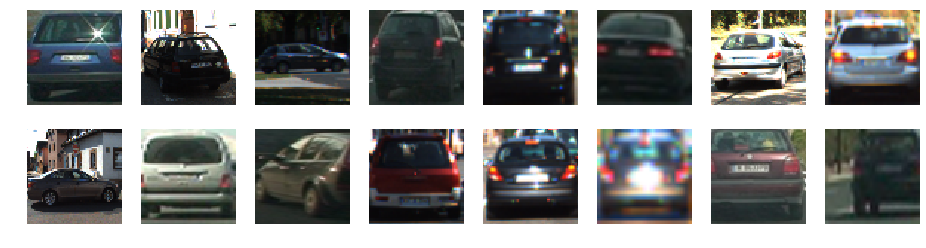

In [3]:
# display positive samples
print("Number of positive images: {}".format(len(vehicles)))
pos_sample = imread(vehicles[0])
print("Image size is {}".format(pos_sample.shape))
print("Image type: {}".format(pos_sample.dtype))
cols = 8
rows = 2
pos_img_samples= random.sample(vehicles, cols*rows)
fig, axes = plt.subplots(rows, cols, figsize=(2*cols,2*rows))
for img, ax in zip(pos_img_samples, axes.flatten()) :
    img = imread(img)
    ax.imshow(img)
    ax.axis('off')

Number of negative images: 8968
Image size is (64, 64, 3)
Image type: uint8


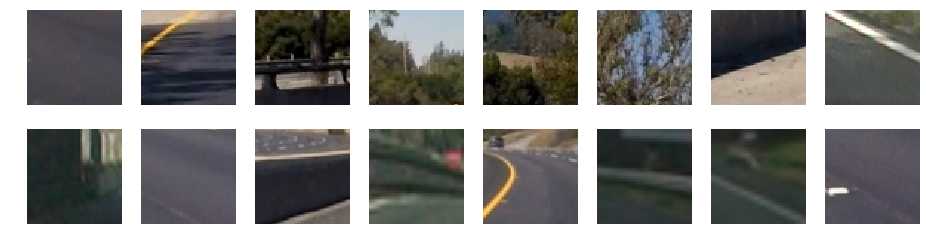

In [4]:
# display negative samples
print("Number of negative images: {}".format(len(non_vehicles)))
neg_sample = imread(non_vehicles[0])
print("Image size is {}".format(neg_sample.shape))
print("Image type: {}".format(neg_sample.dtype))
cols = 8
rows = 2
neg_img_samples= random.sample(non_vehicles, cols*rows)
fig, axes = plt.subplots(rows, cols, figsize=(2*cols,2*rows))
for img, ax in zip(neg_img_samples, axes.flatten()) :
    img = imread(img)
    ax.imshow(img)
    ax.axis('off')

In [5]:
# split data, train data:test data = 0.8:0.2
train_vehicles = []
test_vehicles= []
train_non_vehicles = []
test_non_vehicles = []

def split_by_indices(path, source, target_train_set=[], target_test_set=[], indices_range=()):
    start, end = indices_range
    img_files = glob.glob(os.path.join(path, "*.*"))
    for img in img_files:
        index = int(img.split("image")[1].split(".")[0])
        if start <= index <= end:
            target_test_set.append(source.index(img))
        else:
            target_train_set.append(source.index(img))
            

def split_by_random(path, source, target_train_set=[], target_test_set=[]):
    img_files = glob.glob(os.path.join(path, "*.*"))
    train, test = train_test_split(img_files, test_size=0.2, shuffle=True)
    target_train_set.extend([source.index(img) for img in train])
    target_test_set.extend([source.index(img) for img in test])
    
split_by_indices("./vehicles/GTI_Far/", vehicles, target_train_set=train_vehicles, \
                 target_test_set=test_vehicles, indices_range=(786, 974))
split_by_indices("./vehicles/GTI_Left/", vehicles, target_train_set=train_vehicles, \
                 target_test_set=test_vehicles, indices_range=(778, 974))
split_by_indices("./vehicles/GTI_Right/", vehicles, target_train_set=train_vehicles, \
                 target_test_set=test_vehicles, indices_range=(803, 974))

split_by_indices("./vehicles/GTI_MiddleClose/", vehicles, target_train_set=train_vehicles, \
                 target_test_set=test_vehicles, indices_range=(398, 494))
split_by_random("./vehicles/KITTI_extracted/", vehicles, target_train_set=train_vehicles, \
                target_test_set=test_vehicles)
split_by_random("./non-vehicles/*/", non_vehicles, target_train_set=train_non_vehicles, \
                target_test_set=test_non_vehicles)

print("-"*50)
print(f"positive train data size: {len(train_vehicles)}")
print(f"positive test data size: {len(test_vehicles)}")
print(f"positive train data ratio: {len(train_vehicles)/len(vehicles)}")
print(f"positive test data ratio: {len(test_vehicles)/len(vehicles)}")

print("-"*50)
print(f"negative train data size: {len(train_non_vehicles)}")
print(f"negative test data size: {len(test_non_vehicles)}")
print(f"negative train data ratio: {len(train_non_vehicles)/len(non_vehicles)}")
print(f"negative test data ratio: {len(test_non_vehicles)/len(non_vehicles)}")


--------------------------------------------------
positive train data size: 7033
positive test data size: 1759
positive train data ratio: 0.7999317561419472
positive test data ratio: 0.20006824385805277
--------------------------------------------------
negative train data size: 7174
negative test data size: 1794
negative train data ratio: 0.7999553969669938
negative test data ratio: 0.20004460303300625


# Calculation features
The image size is $64 \times 64$, $8 \times 8$ pixels per cell, $2 \times 2$ cells per block, the stride is equal to block size. The block size is $16 \times 16$.
So the number of blocks at each side is:
$$\text{block_num} = \left( \frac{64 - 16}{16} + 1 \right)^2 = 16$$
Then there are $16 \times 4 = 64$ blocks per image.
So, for per color per orientation, there are $64$ features.

# Plot HOG Features

In [6]:
# dictonary of colorspaces
colorspace = {"RGB": cv2.COLOR_BGR2RGB, "HSV": cv2.COLOR_BGR2HSV, "HLS": cv2.COLOR_BGR2HLS, \
              "YUV": cv2.COLOR_BGR2YUV, "YCrCb": cv2.COLOR_BGR2YCrCb, "LUV": cv2.COLOR_BGR2LUV}

# parameters
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
block_norm = "L2-Hys"
visualize = True
feature_vector = True
transform_sqrt = True

In [7]:
def visualize_hog_feature(images, channels=["R", "G", "B"], orientations=9, pixels_per_cell=(8, 8), \
                         cells_per_block=(2, 2), block_norm="L2-Hys", visualize=True, \
                         feature_vector=True, transform_sqrt=True):
    img_files = random.sample(images, 2)
    fig, axes = plt.subplots(2, 4, figsize=(14, 7))
    for ax in axes.flatten():
        ax.axis('off')
    for img, ax in zip(img_files, axes):
        image = cv2.imread(img)
        ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        image = cv2.cvtColor(image, colorspace["".join(channels)])
        for i in range(image.shape[2]):
            channel = np.maximum(image[:,:,i], 0)
            features, hog_image = hog(channel, orientations, pixels_per_cell, \
                         cells_per_block, block_norm=block_norm, visualize=visualize, \
                         transform_sqrt=transform_sqrt, feature_vector=feature_vector)
            ax[i+1].imshow(hog_image)
    axes[0][0].set_title('Original')
    for i in range(3):
        axes[0][i+1].set_title(f"Hog in {channels[i]} channel")

For soma positive samples:


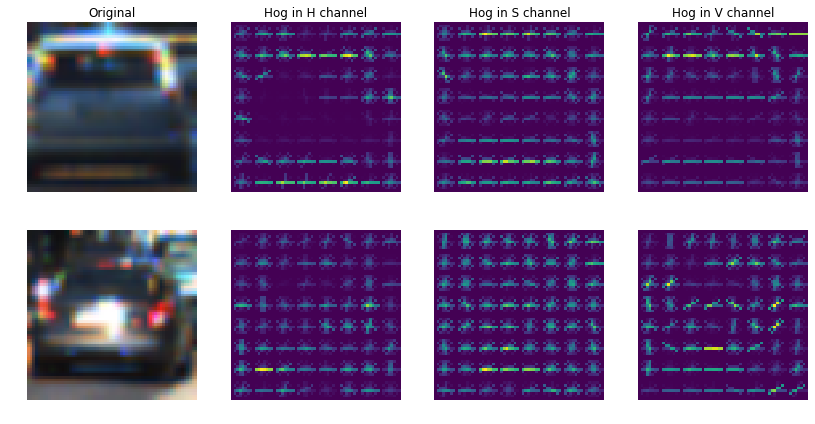

In [8]:
# get the hog image for some positive sample 
print("For soma positive samples:")
visualize_hog_feature(vehicles, channels=["H", "S", "V"], orientations=orientations, \
                      pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, \
                      block_norm=block_norm, visualize=visualize, feature_vector=feature_vector, \
                      transform_sqrt=transform_sqrt)

For soma negative samples:


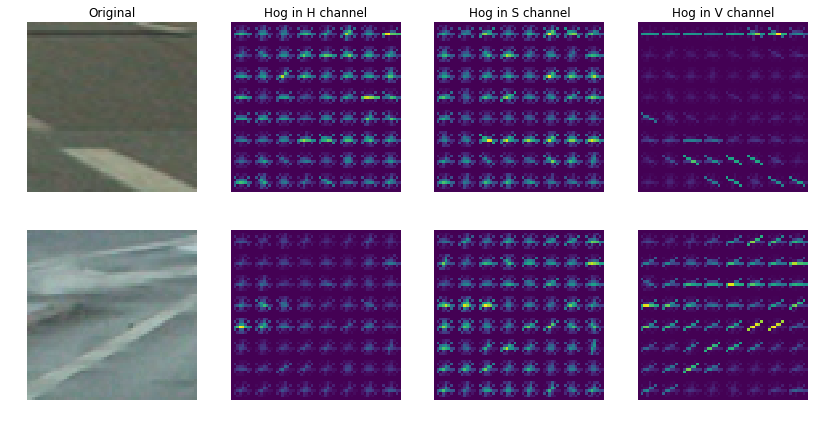

In [9]:
# get the hog image for some negative sample
print("For soma negative samples:")
visualize_hog_feature(non_vehicles, channels=["H", "S", "V"], orientations=orientations, \
                      pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, \
                      block_norm=block_norm, visualize=visualize, feature_vector=feature_vector, \
                      transform_sqrt=transform_sqrt)

# Test with different colorspaces

In [8]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

def extract_hog_features(images, colorspace=colorspace["RGB"], orientations=9, pixels_per_cell=(8, 8), \
                     cells_per_block=(2, 2), block_norm="L2-Hys"):
    features = []
    for img in images:
        hog_features = []
        image = cv2.imread(img)
        feature_image = cv2.cvtColor(image, colorspace)
        for channel in range(feature_image.shape[2]):
            hog_features.append(hog(feature_image[:,:,channel], orientations=orientations, \
                pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, block_norm=block_norm, \
                visualize=False, feature_vector=feature_vector))
        hog_features = np.ravel(hog_features)
        features.append(hog_features)
    return np.array(features)

def SVC_hog(colorspace=colorspace["RGB"], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), \
               block_norm="L2-Hys"):
    vehicles_features = extract_hog_features(vehicles, colorspace=colorspace, orientations=orientations, \
                                        pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, \
                                        block_norm=block_norm)
    non_vehicles_features = extract_hog_features(non_vehicles, colorspace=colorspace, orientations=orientations, \
                                            pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, \
                                            block_norm=block_norm)
    standard_scaler = StandardScaler()
    # create train data and normalize the data
    X_train = np.vstack((vehicles_features[train_vehicles], \
                         non_vehicles_features[train_non_vehicles])).astype(np.float64)
    X_train = standard_scaler.fit_transform(X_train)
    # create test data and normalize
    X_test = np.vstack((vehicles_features[test_vehicles], \
                        non_vehicles_features[test_non_vehicles])).astype(np.float64)
    X_test = standard_scaler.fit_transform(X_test)
    
    # create labels
    y_train = np.hstack((np.ones(len(vehicles_features[train_vehicles])), \
                         np.zeros(len(non_vehicles_features[train_non_vehicles]))))
    y_test = np.hstack((np.ones(len(vehicles_features[test_vehicles])), \
                        np.zeros(len(non_vehicles_features[test_non_vehicles]))))
    model = LinearSVC()
    model = model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    print("Accuracy: {:.4f}".format(accuracy))

In [11]:
for key in colorspace.keys():
    print("-"*50)
    print(f"Colorspace: {key}")
    SVC_hog(colorspace=colorspace[key], orientations=orientations, pixels_per_cell=pixels_per_cell,\
           cells_per_block=cells_per_block, block_norm=block_norm)

--------------------------------------------------
Colorspace: RGB
Accuracy: 0.9628
--------------------------------------------------
Colorspace: HSV
Accuracy: 0.9845
--------------------------------------------------
Colorspace: HLS
Accuracy: 0.9831
--------------------------------------------------
Colorspace: YUV
Accuracy: 0.9848
--------------------------------------------------
Colorspace: YCrCb
Accuracy: 0.9865
--------------------------------------------------
Colorspace: LUV
Accuracy: 0.9854


Here we can see that colorspace **YCrCb** gives the highest accuracy.

# Test with different orientations

In [147]:
orientation_list = [7, 8, 9, 10, 11]
for orientation in orientation_list:
    print("-"*50)
    print("Orientation: {}".format(orientation))
    train_model(colorspace=colorspace["YCrCb"], orientations=orientation, pixels_per_cell=pixels_per_cell,\
           cells_per_block=cells_per_block, block_norm=block_norm)

--------------------------------------------------
Orientation: 7
Accuracy: 0.9868
--------------------------------------------------
Orientation: 8
Accuracy: 0.9876
--------------------------------------------------
Orientation: 9
Accuracy: 0.9879
--------------------------------------------------
Orientation: 10
Accuracy: 0.9910
--------------------------------------------------
Orientation: 11
Accuracy: 0.9885


So the orientation with highest accuracy is $10$.

# Plot color histograms using HSV

In [9]:
# parameters
orientations = 10
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
block_norm = "L2-Hys"
visualize = True
feature_vector = True
transform_sqrt = True
spatial_size = (32, 32)
hist_bins = 64
color = colorspace["YCrCb"]

# dictonary of bin values
hist_ranges = {"RGB": [(0, 256), (0, 256), (0, 256)],
              "HSV": [(0, 256), (0, 256), (0, 256)],
              "HLS": [(0, 256), (0, 256), (0, 256)],
              "YUV": [(0, 256), (0, 256), (0, 256)],
              "YCrCb": [(0, 256), (0, 256), (0, 256)], 
              "LUV": [(0,192),(0,256),(0,256)]}

In [10]:
# compute binned functions
def bin_spatial(img, size=(64, 64)):
    features = cv2.resize(img, size).ravel()
    return features

# compute color histogram features
def color_hist(img, nbins=32, bins_range=[(0, 256)]*3, visualize=False):
    channel_hist = [np.histogram(img[:,:,i], bins=nbins, range=bins_range[i]) for i in range(img.shape[2])]
    bin_edges = [hist[1] for hist in channel_hist]
    channel_hist = [hist[0] for hist in channel_hist]
    hist_features = np.concatenate(channel_hist)
    if visualize:
        return (channel_hist, bin_edges, hist_features)
    else:
        return hist_features

In [11]:
# plot color histograms using HSV
def color_histograms_plot(images, channels=["R", "G", "B"], nbins=32):
    color = colorspace["".join(channels)] 
    imgs = random.sample(images, 2)
    fig, axes = plt.subplots(2, 4, figsize=(14, 7))
    for img, ax in zip(imgs, axes) :
        image = cv2.imread(img)
        ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax[0].axis('off')
        image = cv2.cvtColor(image, color)
        nbins = nbins
        channel_hist, bin_edges, hist_features = color_hist(image, nbins=nbins, 
                                                bins_range=hist_ranges["".join(channels)], visualize=True)
        width=[(b[1]-b[0]) for b in bin_edges]
        for i in range(len(channel_hist)):
            ax[i+1].bar(bin_edges[i][:-1], channel_hist[i], width=width[i])
    axes[0][0].set_title('Original')
    for i in range(3) :
        axes[0][i+1].set_title(f"Histogram in {channels[i]} channel")

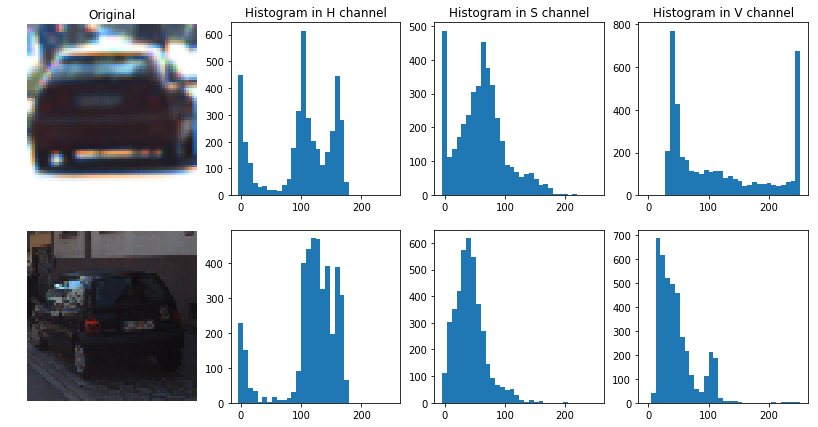

In [159]:
# for vehicles images
color_histograms_plot(vehicles, channels=["H", "S", "V"], nbins=32)

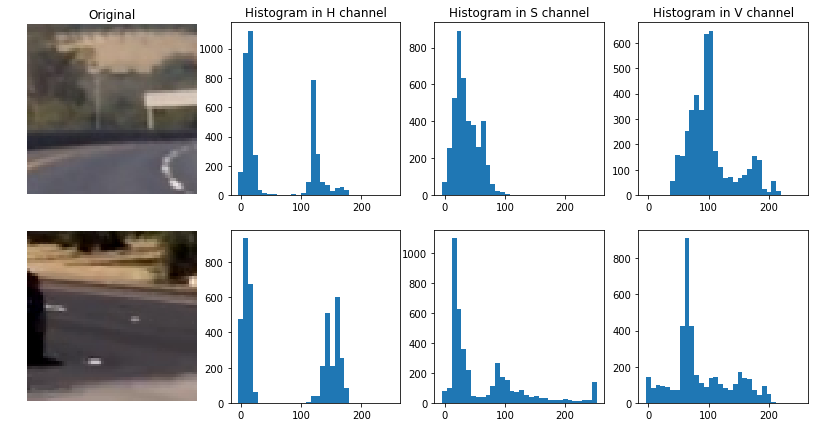

In [160]:
# for non-vehicles images
color_histograms_plot(non_vehicles, channels=["H", "S", "V"], nbins=32)

# Plot spatial features

In [12]:
# extract image features
def extract_spatial_features(images, colorspace, spatial_size, hist_bins, hist_range):
    features = []
    for img in images:
        image = cv2.imread(img)
        color_feature_image = cv2.cvtColor(image, colorspace)
        spatial_features = bin_spatial(image, size=spatial_size)
        hist_fearures = color_hist(image, nbins=hist_bins, bins_range=hist_range)
        features.append(np.concatenate((spatial_features, hist_fearures)))
    return np.array(features)

def SVC_color(colorspace=colorspace["RGB"], spatial_size=(32, 32), hist_bins=32, hist_range=hist_ranges["RGB"]):
    vehicles_features = extract_spatial_features(vehicles, colorspace=colorspace, \
                                                 spatial_size=spatial_size, \
                                                 hist_bins=hist_bins, hist_range=hist_range)
    non_vehicles_features = extract_spatial_features(non_vehicles, colorspace=colorspace, \
                                                             spatial_size=spatial_size, \
                                                             hist_bins=hist_bins, hist_range=hist_range)
    standard_scaler = StandardScaler()
    X_train = np.vstack((vehicles_features[train_vehicles], \
                         non_vehicles_features[train_non_vehicles])).astype(np.float64)
    X_train = standard_scaler.fit_transform(X_train)
    X_test = np.vstack((vehicles_features[test_vehicles], \
                        non_vehicles_features[test_non_vehicles])).astype(np.float64)
    X_test = standard_scaler.fit_transform(X_test)
    
    y_train = np.hstack((np.ones(len(vehicles_features[train_vehicles])), \
                         np.zeros(len(non_vehicles_features[train_non_vehicles]))))
    y_test = np.hstack((np.ones(len(vehicles_features[test_vehicles])), \
                        np.zeros(len(non_vehicles_features[test_non_vehicles]))))
    model = LinearSVC()
    model = model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    print("Accuracy: {:.4f}".format(accuracy))

In [154]:
spatial_size = (32, 32)
hist_bins = 32

# test with different colospace
for key in colorspace.keys():
    print("-"*50)
    print(f"Colorspace: {key}")
    SVC_color(colorspace=colorspace[key], spatial_size=spatial_size, hist_bins=hist_bins, \
              hist_range=hist_ranges[key])

--------------------------------------------------
Colorspace: RGB
Accuracy: 0.9364
--------------------------------------------------
Colorspace: HSV
Accuracy: 0.9355
--------------------------------------------------
Colorspace: HLS
Accuracy: 0.9355
--------------------------------------------------
Colorspace: YUV
Accuracy: 0.9330
--------------------------------------------------
Colorspace: YCrCb
Accuracy: 0.9370
--------------------------------------------------
Colorspace: LUV
Accuracy: 0.9299


In [15]:
color = colorspace["HSV"]
hist_range = hist_ranges["HSV"]
for spatial in [8, 16, 32]:
    for hist_bin in [16, 32, 64]:
        print("-"*50)
        print(f"Spatial: {spatial}")
        print(f"Hist bin: {hist_bin}")
        SVC_color(colorspace=colorspace["YCrCb"], spatial_size=spatial_size, hist_bins=hist_bins, \
                  hist_range=hist_ranges["YCrCb"])

--------------------------------------------------
Spatial: 8
Hist bin: 16
Accuracy: 0.9431
--------------------------------------------------
Spatial: 8
Hist bin: 32
Accuracy: 0.9440
--------------------------------------------------
Spatial: 8
Hist bin: 64
Accuracy: 0.9437
--------------------------------------------------
Spatial: 16
Hist bin: 16
Accuracy: 0.9429
--------------------------------------------------
Spatial: 16
Hist bin: 32
Accuracy: 0.9443
--------------------------------------------------
Spatial: 16
Hist bin: 64
Accuracy: 0.9434
--------------------------------------------------
Spatial: 32
Hist bin: 16
Accuracy: 0.9440
--------------------------------------------------
Spatial: 32
Hist bin: 32
Accuracy: 0.9434
--------------------------------------------------
Spatial: 32
Hist bin: 64
Accuracy: 0.9431


The parameters, spatial and hist bins, will result in highest accuracy when spatial = $32$ , hist bins = $64$.

The optimal parameters:
- colorspace: **YCrCb**
- orientation: $10$
- pixel per cell: $(8, 8)$
- cells per block: $2 \times 2$
- color histogram bins: $64$ 
- spatial bin: $(32, 32)$

# Detect vehicles in video

In [13]:
# train the model
# parameters
orientations = 10
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
block_norm = "L2-Hys"
visualize = False
feature_vector = True
transform_sqrt = True
spatial_size = (32, 32)
hist_bins = 64
color = colorspace["YCrCb"]
hist_range = hist_ranges["YCrCb"]

In [14]:
vehicles_features = extract_spatial_features(vehicles, colorspace=color, spatial_size=spatial_size, \
                                             hist_bins=hist_bins, hist_range=hist_range)
non_vehicles_features = extract_spatial_features(non_vehicles, colorspace=color, spatial_size=spatial_size, \
                                                 hist_bins=hist_bins, hist_range=hist_range)
standard_scaler = StandardScaler()
X_train = np.vstack((vehicles_features[train_vehicles], \
                     non_vehicles_features[train_non_vehicles])).astype(np.float64)
X_train = standard_scaler.fit_transform(X_train)
X_test = np.vstack((vehicles_features[test_vehicles], \
                    non_vehicles_features[test_non_vehicles])).astype(np.float64)
X_test = standard_scaler.fit_transform(X_test)

y_train = np.hstack((np.ones(len(vehicles_features[train_vehicles])), \
                     np.zeros(len(non_vehicles_features[train_non_vehicles]))))
y_test = np.hstack((np.ones(len(vehicles_features[test_vehicles])), \
                    np.zeros(len(non_vehicles_features[test_non_vehicles]))))
model = LinearSVC()
model = model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
print("Accuracy: {:.4f}".format(accuracy))

Accuracy: 0.9375


In [15]:
# detect vehicles in give image
def detect_vehicles(image, start, end, scale, model, scaler):
    # parameters
    orientations = 10
    pixels_per_cell = (8, 8)
    cells_per_block = (2, 2)
    block_norm = "L2-Hys"
    spatial_size = (32, 32)
    hist_bins = 64
    color = colorspace["YCrCb"]
    bins_range = hist_ranges["YCrCb"]
    window = (64, 64)
    
    ori_img = np.copy(image)
    search_img = image[start:end, :, :]
    search_img = cv2.cvtColor(search_img, color)
    if scale != 1:
        search_img = cv2.resize(search_img, (np.int(search_img.shape[1]/scale), np.int(search_img.shape[0]/scale)))
    channel_1 = search_img[:, :, 0]
    channel_2 = search_img[:, :, 1]
    channel_3 = search_img[:, :, 2]
    # blocks 
    blocks_num_x = (channel_1.shape[1] // pixels_per_cell[0]) - 1
    blocks_num_y = (channel_2.shape[0] // pixels_per_cell[1]) - 1
    features_per_block = orientations * cells_per_block[0] ** 2
    # block number
    blocks_per_window = (window[0] // pixels_per_cell[0]) - 1
    # stride
    cells_per_step = cells_per_block[0]
    # steps in x, y axis
    steps_x = (blocks_num_x - blocks_per_window) // cells_per_step
    steps_y = (blocks_num_y - blocks_per_window) // cells_per_step
    #compute hog feature of entire image for each channel
    hog_1 = hog(channel_1, orientations, pixels_per_cell, cells_per_block, block_norm=block_norm, \
               transform_sqrt=True, feature_vector=False)
    hog_2 = hog(channel_2, orientations, pixels_per_cell, cells_per_block, block_norm=block_norm, \
               transform_sqrt=True, feature_vector=False)
    hog_3 = hog(channel_3, orientations, pixels_per_cell, cells_per_block, block_norm=block_norm, \
               transform_sqrt=True, feature_vector=False)
    box_list = []
    for box_x in range(steps_x):
        for box_y in range(steps_y):
            pos_x = box_x * cells_per_step
            pos_y = box_y * cells_per_step
            # extract hog for the patch
            hog_feat_1 = hog_1[pos_y:pos_y + blocks_per_window, pos_x:pos_x + blocks_per_window].ravel()
            hog_feat_2 = hog_2[pos_y:pos_y + blocks_per_window, pos_x:pos_x + blocks_per_window].ravel()
            hog_feat_3 = hog_3[pos_y:pos_y + blocks_per_window, pos_x:pos_x + blocks_per_window].ravel()
            hog_features = np.hstack((hog_feat_1, hog_feat_2, hog_feat_3))
            left_x = pos_x * pixels_per_cell[0]
            top_y = pos_y * pixels_per_cell[1]
            # extract the image patch
            patch = cv2.resize(search_img[top_y : top_y + window[0], left_x : left_x + window[0]], (64, 64))
            # get color features
            spatial_features = bin_spatial(patch, size=spatial_size)
            hist_features = color_hist(patch, nbins=hist_bins, bins_range=bins_range)
            # scale features and make predictions
            test_features = scaler.transform(np.hstack((spatial_features, hist_features, \
                                                          hog_features)).reshape(1, -1))
            test_prediction = model.predict(test_features)
            
            if test_predict == 1:
                box_x_left = np.int(left_x * scale)
                box_y_draw = np.int(top_y * scale)
                window_draw = np.int(window[0] * scale)
                cv2.rectangle(ori_img, (box_x_left, top_y_draw + start), \
                             (box_x_left + window_draw, top_y_draw + window_draw + start), \
                             (0, 0, 1), 6)
                box_list.append(((box_x_left, top_y_draw + start), \
                                 (box_x_left + window_draw, top_y_draw + window_draw + start)))
    return box_list

# draw box
def draw_box(image, box_list, color=(0, 0, 255)):
    for box in box_list:
        cv2.rectangle(image, box[0], box[1], color, 6)
    return image

# sliding window scales and the search y-range
y_range = {1.0 : (380, 508), 1.5 : (380, 572), 2.0 : (380, 636), 2.5 : (380, 700)}

In [16]:
def add_heat(heatmap, box_list):
    for box in box_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(image, labels):
    for vehicle_number in range(1, labels[1]+1):
        non_zero = (labels[0] == vehicle_number).nonzero()
        non_zero_y = np.array(non_zero[0])
        non_zero_x = np.array(non_zero[1])
        box = ((np.min(non_zero_x), np.min(non_zero_y)), (np.max(non_zero_x), np.max(non_zero_y)))
        cv2.rectangle(image, box[0], box[1], (0,255,0), 6)
    return image

In [17]:
video_dim = (1280, 720)

class vehicle_detection:
    def __init__(self, iteration=25, update=2, threshold=8):
        self.count = 0
        # box for each frame
        self.out_img = None
        # labelled boxes
        self.out_img_label = None
        # vehicle labels
        self.labels = [None, 0]
        # list of box lists from last n iterations
        self.box_list_n_iter = []
        # frame numbers to smooth over, which is equal to iterations
        self.frames_smooth = iteration
        # frame numbers to update after detection
        self.frames_update = update
        # threshold for heatmap
        self.threshold = threshold
        # heatmap
        self.heat = np.zeros(video_dim[::-1])
        self.heatmap = np.copy(self.heat)

    def process_image(self, image):
        self.count += 1
        self.image = image
        out_img = np.copy(image)
        img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        for scale, i_color in zip(y_range.keys(), np.linspace(0, 1, len(y_range))) :
            start,stop = y_range[scale]
            box_list = detect_vehicles(img, start, stop, scale, model, standard_scaler)
            color = tuple(255 * c for c in plt.cm.rainbow(i_color)[:3])
            self.out_img = draw_boxes(out_img, box_list, color)
        self.box_list_n_iter.append(box_list)
        if self.count % self.frames_update == 0 :
            for box_list in self.box_list_n_iter :
                self.heat = add_heat(self.heat, box_list)
            self.heat = apply_threshold(self.heat, self.threshold)
            self.heatmap = np.clip(self.heat, 0, 255)
            self.labels = label(self.heatmap)
            self.heat = np.clip(self.labels[0], 0, 1) * 2
        if len(self.box_list_n_iter) > self.frames_smooth :
            self.box_list_n_iter.pop(0)
        self.out_img_label = draw_labeled_bboxes(np.copy(image), self.labels)
        return self.out_display()
    
    def out_display(self) :
        imgA = cv2.resize(self.out_img, None, fx=0.4, fy=0.4, interpolation=cv2.INTER_AREA)
        imgB = np.uint8(self.heatmap * 255 / (0.001 + np.max(self.heatmap)))
        imgB = cm.inferno(imgB)[:, :, :3] * 255
        imgB = imgB.astype(np.uint8)
        imgB = cv2.addWeighted(imgB, 1, self.image, 0.4, 0)
        imgB = cv2.resize(imgB, None, fx=0.4, fy=0.4, interpolation=cv2.INTER_AREA)
        hA,wA = imgA.shape[:2]
        h_text = int(video_dim[1] / 2 - hA)
        textA = np.zeros((h_text, wA,3), dtype=np.uint8)
        textB = np.zeros((video_dim[1] - h_text - 2 * hA, wA, 3), dtype=np.uint8)
        textA[:, :, 1] = 200
        textB[:, :, 1] = 200
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(textA,'Bounding boxes', (10, h_text - 20), font, 1, (0, 0, 0), 3, cv2.LINE_AA)
        cv2.putText(textB,'Heatmap', (10, h_text - 20), font, 1, (0, 0, 0), 3, cv2.LINE_AA)
        img_combined_right = np.vstack((textA, imgA, textB, imgB))
        return np.hstack((self.out_img_labeled, img_combined_right))

    def export_frame(self, video, output):
        print("Exporting frames...")
        vidcap = cv2.VideoCapture(video)
        success, image = vidcap.read()
        count = 0
        success = True
        while success:
            success, image = vidcap.read()
            cv2.imwrite(f"{output}frame{count}.jpg", image)
            count += 1
        vidcap.release()
        print("Complete!")

In [21]:
# test with video

frame_output = "./frame_output/"
if not os.path.isdir(frame_output):
    os.makedirs(frame_output)
video = "./test_video.mp4"

vd = vehicle_detection(iteration=1, update=1, threshold=2)
vd.export_frame(video, frame_output)
images = glob.glob(f"{frame_output}*.*")
rows = len(frame_output)
cols = 2

Exporting frames...
Complete!


In [24]:
def test_image_function(processing_function):
    images = []
    for i in range(rows):
        count = random.randint(0, 30)
        feature_image = np.array(Image.open(f"{frame_output}frame{count}.jpg"))
        input_img = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
        result_img = processing_function(input_img)
        images.append(result_img)
    fig, axes = plt.subplots(rows, cols, figsize=(30, 15)) 
    for i in range(len(images)):
        cur_img = images[i]
        axes[i/2, i%2].imshow(cur_img)
    fig.subplots_adjust(hspace=0)
    fig.show()

In [25]:
test_image_function(vd.process_image)

ValueError: operands could not be broadcast together with shapes (1,9144) (3264,) (1,9144) 

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

vd = vehicle_detection()
clip = VideoFileClip("./test_video.mp4")
clip = clip.fl_image(vd.process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


In [48]:
# import matplotlib.image as mpimg
# fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 3*rows))
# for image, ax in zip(images, axes):
#     img = mpimg.imread(image)
#     ax[0].imshow(img)
#     ax[1].imshow(vd.process_image(img))
# print("Process Complete")